pygame 2.0.1 (SDL 2.0.14, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


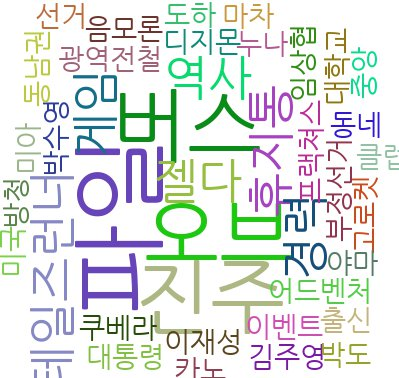

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")  # Error가 아닌 warning들은 무시

import requests
from bs4 import BeautifulSoup
import re # regular expression

# 크롤링할 사이트 정의
source_url = "https://namu.wiki/RecentChanges"

# html 구조에 기반해서 크롤링 수행
req = requests.get(source_url)
html = req.content   # Response의 body를 binary 파일 형태로 access
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name = 'table')
table_body = contents_table.find(name = 'tbody')
table_rows = table_body.find_all(name = 'tr')

# a 태그의 href 속성을 리스트로 추출, 크롤링할 페이지 리스트 생성
page_url_base = 'https://namu.wiki'
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:    # exclude image links
            page_urls.append(page_url)
# 중복 url 제거
page_urls = list(set(page_urls))

columns = ['title', 'category','content_text']
df = pd.DataFrame(columns = columns)
# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만든다.
for page_url in page_urls:
    # 사이트 html 구조에 기반해서 크롤링 수행
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name = 'article')
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우 확인
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
    content_paragraphs = contents_table.find_all(name = 'div', attrs = {"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출. 만약 없는 경우 빈 문자열로 대체
    if title is not None:
        row_title = title.text.replace('\n', ' ')
    else:
        row_title = ''
        
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace('\n',' '))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
    
    # 페이지 내 카테고리 정보에서 "분류"라는 단어와 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우 빈 문자열로 대체
    if category is not None:
        row_category = category.text.replace('\n', ' ')
    else:
        row_category = ''
    
    #모든 정보를 하나의 데이터 프레임에 저장.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index = True)
    
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('',text) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    return result

# 각 feature마다 데이터 전처리 적용
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))

# corpus 생성
# 각 feature마다 말 뭉치 생성
title_corpus = ''.join(df['title'].tolist())
category_corpus = ''.join(df['category'].tolist())
content_corpus = ''.join(df['content_text'].tolist())

# 불용어 사전
with open('korean_stopwords.txt', encoding = 'utf8')as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

# 불용어 사전 + 나무위키 페이지에 맞는 불용어 추가
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가','모든', '사용','매우', '가장',
                      '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물',
                      '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)
    
from konlpy.tag import Okt
from collections import Counter
from IPython.display import Image
import random
import pytagcloud
import webbrowser

# title_corpus 시각화
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x: count[x] for x in count if len(x) >1})
remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize = 80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size = (400, 400), fontname = 'NanumGothic', rectangular = False)

Image(filename = 'title_wordcloud.jpg')